<a href="https://colab.research.google.com/github/MudSnail/Colab_Practice/blob/main/Feature_Importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
#import base libraries
import pandas as pd
import numpy as np
import copy
import pickle
import cloudpickle

#Sklearn - Pipelines, Training
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler

#Classification Models
from sklearn.ensemble import RandomForestClassifier

#Model metrics
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

#misc
import warnings
warnings.filterwarnings('ignore')

In [24]:
#Connect to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# User Defined Functions

In [25]:
def get_scores(model, x, y):
  """
  Input: model, x = X_test variable, y = y_test variable
  Output: The scores and classification report for the model
  """
  #Predict X_test
  y_prediction = model.predict(x)

  #Print measure scores
  print(f"Accuracy: {accuracy_score(y, y_prediction)}")
  print(f"Balanced Accuracy: {balanced_accuracy_score(y, y_prediction)}")
  print(f"F1 Score: {f1_score(y, y_prediction, average='micro')}")
  print(f"Precision Score: {precision_score(y, y_prediction, average='micro')}")
  print(f"Recall Score: {recall_score(y, y_prediction, average='micro')}")
  print(f"ROC AUC Score: {roc_auc_score(y, model.predict_proba(x),multi_class='ovr', average='macro')}")

  #print full classification report
  print(classification_report(y, y_prediction))


def create_class_matrix(model, x, y):
  """
  Input: model, x = X_test variable, y = y_test variable
  Output: A confusion matrix plot with all class labels
  """
  #Predict X_test
  y_prediction = model.predict(x)

  #Create a confusion matrix
  matrix = confusion_matrix(y, y_prediction)

  #Visualize the matrix with Seaborn

  #Write title to display accuracy score
  score = balanced_accuracy_score(y, y_prediction)
  all_sample_title = 'RF Accuracy Score: {0}%'.format(round(score,3)*100)

  #Set figure shape
  plt.figure(figsize=(9,9))

  #Use heatmap
  p = sns.heatmap(matrix, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap="mako")

  #Label the plot
  label = [1,2,5,6,8,10,11,12,13,14,15,16,17,18,19]
  p.set_ylabel('Actual Label', size=16)
  p.set_xlabel('Predicted Label', size = 16)
  p.set_xticklabels(label)
  p.set_yticklabels(label)
  p.set_title(all_sample_title, size = 18)

def plot_features(model, X):
  """
  Input: model and X = your X before train split
  Output: A confusion matrix plot with all class labels
  """
  #Find which features were most important
  importances = model.feature_importances_
  std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
  feature_names = [f"feature {i}" for i in range(X.shape[1])]

  forest_importances = pd.Series(importances, index=feature_names)

  fig, ax = plt.subplots()
  forest_importances.plot.bar(yerr=std, ax=ax)
  ax.set_title("Feature importances using MDI")
  ax.set_ylabel("Mean decrease in impurity")
  fig.tight_layout()

def print_importance(model, x):
  """
  Input: Model and X prior to split]
  Output: Series of feature importance coefficients in descending order
  """
  feature_importances = pd.DataFrame(model.feature_importances_, index = x.columns, columns = ['importance']).sort_values('importance', ascending = False)
  print(feature_importances)

# Read Data and Sample

In [26]:
#Read in CSVs
james_bay = pd.read_csv('/content/drive/MyDrive/james_bay_data.csv')
labrador = pd.read_csv('/content/drive/MyDrive/labrador_data.csv')
simcoe = pd.read_csv('/content/drive/MyDrive/simcoe_york_data.csv')

In [27]:
#List dataframes to add to james_bay
dfs = [labrador, simcoe]

#Merged data
merged_data = james_bay.append(dfs)

#Print shape and check new data
print(merged_data.shape)
merged_data.head()

(8917500, 13)


,B01,B06,B11,B07,B05,B03,B09,B12,B8A,B04,B08,B02,Class
0,0.0055,0.0017,0.0009,0.0016,0.0026,0.0056,0.0001,0.0009,0.0003,0.0032,0.0012,0.0114,0
1,0.0054,0.0020,0.0009,0.0017,0.0021,0.0060,0.0001,0.0005,0.0007,0.0028,0.0014,0.0115,0
2,0.0058,0.0018,0.0007,0.0016,0.0028,0.0060,0.0001,0.0008,0.0007,0.0030,0.0012,0.0124,0
3,0.0057,0.0016,0.0007,0.0016,0.0023,0.0058,0.0001,0.0012,0.0006,0.0031,0.0011,0.0119,0
4,0.0066,0.0013,0.0008,0.0020,0.0029,0.0059,0.0001,0.0008,0.0005,0.0030,0.0014,0.0115,0


In [28]:
#Drop Class = 0 (null values, which equate to 18)
merged_data = merged_data[merged_data.Class != 0]

#Double check value counts
merged_data.Class.value_counts()

15    2836714
18    1050988
1      677877
5      666952
16     646870
13     612009
8      575175
17     512930
12     415493
6      378274
2      151560
11     135890
14      94850
10      86338
19      74619
Name: Class, dtype: int64

In [29]:
#SubSample ~50 000 for each class
df = merged_data.groupby('Class').apply(lambda x: x.sample(n=50000)).reset_index(drop=True)
df.head(4)

,B01,B06,B11,B07,B05,B03,B09,B12,B8A,B04,B08,B02,Class
0,0.0045,0.1316,0.1079,0.1520,0.0688,0.0350,0.1719,0.0554,0.1706,0.0247,0.1629,0.0162,1
1,0.0240,0.1460,0.1341,0.1594,0.0892,0.0517,0.1727,0.0784,0.1732,0.0484,0.1665,0.0376,1
2,0.0045,0.0076,0.0107,0.0098,0.0072,0.0048,0.0506,0.0061,0.0095,0.0046,0.0094,0.0062,1
3,0.0171,0.1311,0.1248,0.1468,0.0752,0.0390,0.1613,0.0687,0.1590,0.0357,0.1531,0.0273,1


# Feature Engineering

## Feature Importance of 4 additional layers

In [30]:
#Create NDVI column (B08-B04)/(B08+B04)
df['NDVI'] = (df.B08 - df.B04)/(df.B08 + df.B04)
#Create Moisture index (B8A-B11)/(B8A+B11)
df['Moisture'] = (df.B8A - df.B11)/(df.B8A + df.B11)
#Create NDWI (B3-B8)/(B3+B8)
df['NDWI'] = (df.B03 - df.B08)/(df.B03 + df.B08)
#create NDSI (B3-B11)/(B3+B11)
df['NDSI'] = (df.B03 - df.B11)/(df.B03 + df.B11)

In [9]:
#Replace infinity values with Nan
df.replace([np.inf, -np.inf], np.nan, inplace=True)

#Fill in infinity values
df.fillna(999, inplace=True)

### Random Forest Model

In [9]:
#Split the Data
y = df['Class']
X = df.drop(['Class'], axis = 1)

#Print data shapes
print(X.shape)
print(y.shape)

(750000, 16)
(750000,)


In [10]:
#Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    random_state=42)

In [11]:
#Instantiate Random Forest
rfc = RandomForestClassifier(random_state=42)

#Fit training data
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Accuracy: 0.6207377777777778
Balanced Accuracy: 0.6208647831322057
F1 Score: 0.6207377777777778
Precision Score: 0.6207377777777778
Recall Score: 0.6207377777777778
ROC AUC Score: 0.9484553872951452
              precision    recall  f1-score   support

           1       0.64      0.57      0.60     15014
           2       0.58      0.66      0.62     14925
           5       0.50      0.47      0.48     14870
           6       0.54      0.64      0.59     15039
           8       0.52      0.49      0.50     15018
          10       0.65      0.57      0.60     14995
          11       0.68      0.76      0.72     14988
          12       0.49      0.37      0.42     14954
          13       0.61      0.67      0.63     15113
          14       0.74      0.75      0.74     14998
          15       0.62      0.67      0.65     15064
          16       0.45      0.31      0.36     15065
          17       0.64      0.72      0.68     15241
          18       0.93      0.89      0.91 

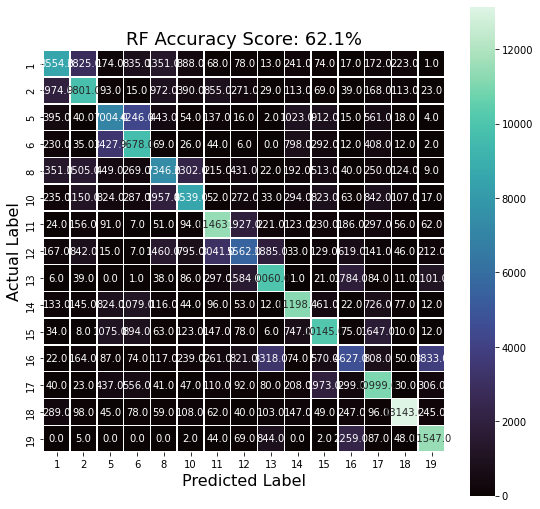

In [13]:
#Print all scores
get_scores(X_test, y_test)

#Print Confusion Matrix
create_class_matrix(X_test, y_test)

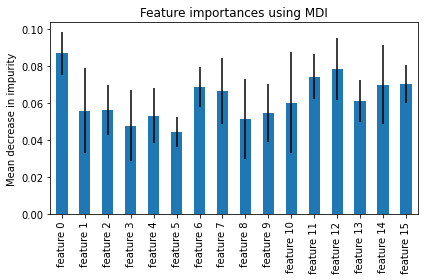

In [15]:
#Plot Feature Importance
plot_features(rfc, X)

In [24]:
#Print Out Feature Importance Coefficients
print_importance(rfc, X)

          importance
B01         0.086904
NDVI        0.078490
B02         0.074307
NDSI        0.070419
NDWI        0.069957
B09         0.068607
B12         0.066560
Moisture    0.061213
B08         0.060195
B11         0.056347
B06         0.055908
B04         0.054631
B05         0.053231
B8A         0.051312
B07         0.047725
B03         0.044193


## Feature Importance with 14 additional layers

In [31]:
#Reference: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/indexdb/
#Reference: https://gisgeography.com/spectral-signature/

#normalized NIR/Blue normalized veg index
df['NIRB'] = (df.B08 - df.B02)/(df.B08 + df.B02)
#green normalized difference veg index
df['NIRB'] = (df.B08 - df.B03)/(df.B08 + df.B03)
#Atmospheric Resistant Green
df['ARG'] = (df.B03 - df.B04)/(df.B03 + df.B04)
#green blue ndvi
df['GB_NDVI'] = (df.B08 - (df.B03 + df.B02))/(df.B08 + (df.B03 + df.B02))
#red blue ndvi
df['RB_NDVI'] = (df.B08 - (df.B04 + df.B02))/(df.B08 + (df.B04 + df.B02))
#green red ndvi
df['GR_NDVI'] = (df.B08 - (df.B03 + df.B04))/(df.B08 + (df.B03 + df.B04))
#GARI
df['GARI'] = (df.B08 - (df.B03 - (df.B02 - df.B04)))/(df.B08 - (df.B03 + (df.B02 - df.B04)))
# yellow veg index
df['yellow'] = (0.723 * df.B03) - (0.597 * df.B04) + (0.206 * df.B06) - (0.278 * df.B09)
#Mid-infrared veg index
df['ARG'] = df.B09/df.B11
#GDVI
df['GDVI'] = df.B08 - df.B03

In [32]:
#Replace infinity values with Nan
df.replace([np.inf, -np.inf], np.nan, inplace=True)

#Fill in infinity values
df.fillna(999, inplace=True)

In [12]:
#Check shape
print(df.shape)

#Check dataframe head
df.head()

(750000, 25)


,B01,B06,B11,B07,B05,B03,B09,B12,B8A,B04,...,NDWI,NDSI,NIRB,ARG,GB_NDVI,RB_NDVI,GR_NDVI,GARI,yellow,GDVI
0,0.0116,0.1352,0.1194,0.1560,0.0751,0.0310,0.1801,0.0631,0.1790,0.0309,...,-0.690927,-0.587766,0.690927,1.508375,0.542519,0.543221,0.465227,0.845539,-0.018251,0.1386
1,0.0137,0.1538,0.1479,0.1764,0.0920,0.0406,0.2006,0.0821,0.1964,0.0425,...,-0.649092,-0.569231,0.649092,1.356322,0.473928,0.463190,0.393209,0.818402,-0.020103,0.1502
2,0.0194,0.1488,0.1342,0.1671,0.0836,0.0421,0.1891,0.0717,0.1856,0.0387,...,-0.617273,-0.522405,0.617273,1.409091,0.429490,0.449287,0.375338,0.865385,-0.014583,0.1358
3,0.0123,0.1305,0.1136,0.1458,0.0618,0.0306,0.1658,0.0611,0.1624,0.0230,...,-0.669368,-0.575589,0.669368,1.459507,0.535022,0.595250,0.484863,0.895945,-0.010817,0.1239
4,0.0163,0.1485,0.1410,0.1698,0.0845,0.0390,0.1928,0.0795,0.1907,0.0382,...,-0.645777,-0.566667,0.645777,1.367376,0.478580,0.483422,0.402477,0.828939,-0.017616,0.1422


### Random Forest Model

In [13]:
#Split the Data
y = df['Class']
X = df.drop(['Class'], axis = 1)

#Print data shapes
print(X.shape)
print(y.shape)

(750000, 24)
(750000,)


In [14]:
#Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    random_state=42)

In [15]:
#Instantiate Random Forest
rf = RandomForestClassifier(random_state=42)

#Fit training data
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Accuracy: 0.6205511111111112
Balanced Accuracy: 0.6206717817648352
F1 Score: 0.6205511111111112
Precision Score: 0.6205511111111112
Recall Score: 0.6205511111111112
ROC AUC Score: 0.9485287201061251
              precision    recall  f1-score   support

           1       0.63      0.57      0.60     15014
           2       0.59      0.66      0.62     14925
           5       0.49      0.47      0.48     14870
           6       0.54      0.65      0.59     15039
           8       0.52      0.48      0.50     15018
          10       0.64      0.57      0.60     14995
          11       0.67      0.77      0.72     14988
          12       0.49      0.35      0.41     14954
          13       0.61      0.67      0.64     15113
          14       0.74      0.74      0.74     14998
          15       0.62      0.67      0.64     15064
          16       0.45      0.32      0.38     15065
          17       0.64      0.72      0.68     15241
          18       0.93      0.90      0.91 

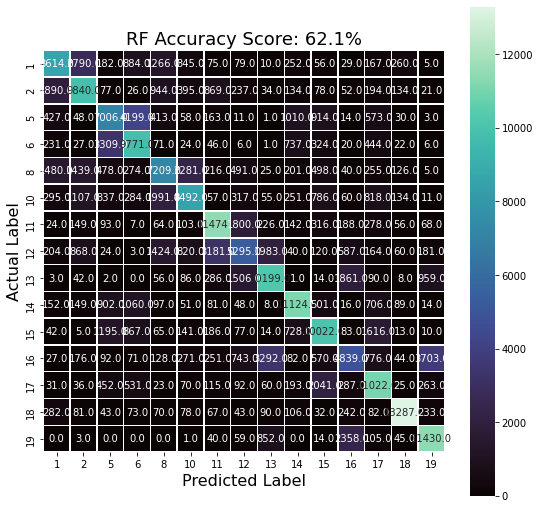

In [19]:
#Print all scores
get_scores(rf, X_test, y_test)

#Print Confusion Matrix
create_class_matrix(rf, X_test, y_test)

          importance
B01         0.063497
GARI        0.054787
NDSI        0.047332
GB_NDVI     0.046879
B12         0.046184
RB_NDVI     0.045593
B11         0.045129
yellow      0.044853
Moisture    0.042989
B09         0.042005
NDVI        0.041457
ARG         0.040991
B02         0.039964
B08         0.039337
B05         0.039269
NIRB        0.037869
B06         0.037320
B8A         0.037243
NDWI        0.037132
GR_NDVI     0.036295
GDVI        0.035598
B07         0.033471
B04         0.033234
B03         0.031572


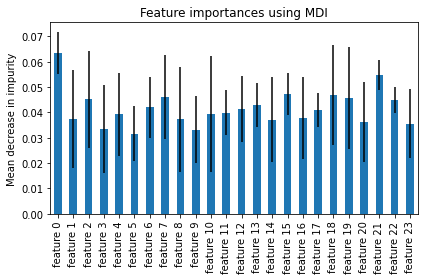

In [20]:
#Print Out Feature Importance Coefficients
print_importance(rf, X)

#Plot Feature Importance
plot_features(rf, X)

## Feature Importance with top features

Using the features in the first model with coefficients over 0.055 and in the second model with features over 0.04

In [34]:
#List Features to Keep
features = ['B01', 'B02', 'B06', 'B08', 'B09', 'B11', 'B12', 'Class',
            'NDVI', 'NDSI', 'NDWI','Moisture', 'GARI', 'GB_NDVI', 'RB_NDVI', 'yellow', 'ARG']

#Extract features into new DF
new_df = df[features]

#Print shape
print(new_df.shape)

#View new dataframe
new_df.head()

(750000, 17)


,B01,B02,B06,B08,B09,B11,B12,Class,NDVI,NDSI,NDWI,Moisture,GARI,GB_NDVI,RB_NDVI,yellow,ARG
0,0.0045,0.0162,0.1316,0.1629,0.1719,0.1079,0.0554,1,0.736674,-0.510147,-0.646286,0.225135,0.875367,0.521719,0.598626,-0.010120,1.593142
1,0.0240,0.0376,0.1460,0.1665,0.1727,0.1341,0.0784,1,0.549558,-0.443488,-0.526123,0.127237,0.828025,0.301798,0.318812,-0.009450,1.287845
2,0.0045,0.0062,0.0076,0.0094,0.0506,0.0107,0.0061,1,0.342857,-0.380645,-0.323944,-0.059406,2.066667,-0.078431,-0.069307,-0.011777,4.728972
3,0.0171,0.0273,0.1311,0.1531,0.1613,0.1248,0.0687,1,0.621822,-0.523810,-0.593961,0.120507,0.862857,0.395624,0.416937,-0.010951,1.292468
4,0.0152,0.0340,0.1554,0.1875,0.1897,0.1605,0.0926,1,0.595745,-0.524941,-0.578947,0.093220,0.821192,0.381215,0.394052,-0.012932,1.181931


### Random Forest Model

In [35]:
#Split the Data
y = new_df['Class']
X = new_df.drop(['Class'], axis = 1)

#Print data shapes
print(X.shape)
print(y.shape)

(750000, 16)
(750000,)


In [36]:
#Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    random_state=42)

#Instantiate Random Forest
rf2 = RandomForestClassifier(random_state=42)

#Fit training data
rf2.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Accuracy: 0.6194844444444444
Balanced Accuracy: 0.6195979125152359
F1 Score: 0.6194844444444444
Precision Score: 0.6194844444444444
Recall Score: 0.6194844444444444
ROC AUC Score: 0.9484711026945905
              precision    recall  f1-score   support

           1       0.63      0.58      0.60     15014
           2       0.59      0.66      0.62     14925
           5       0.50      0.47      0.48     14870
           6       0.54      0.64      0.59     15039
           8       0.51      0.48      0.50     15018
          10       0.64      0.57      0.60     14995
          11       0.68      0.76      0.72     14988
          12       0.48      0.37      0.42     14954
          13       0.61      0.66      0.63     15113
          14       0.73      0.73      0.73     14998
          15       0.61      0.66      0.64     15064
          16       0.46      0.33      0.38     15065
          17       0.63      0.73      0.67     15241
          18       0.93      0.89      0.91 

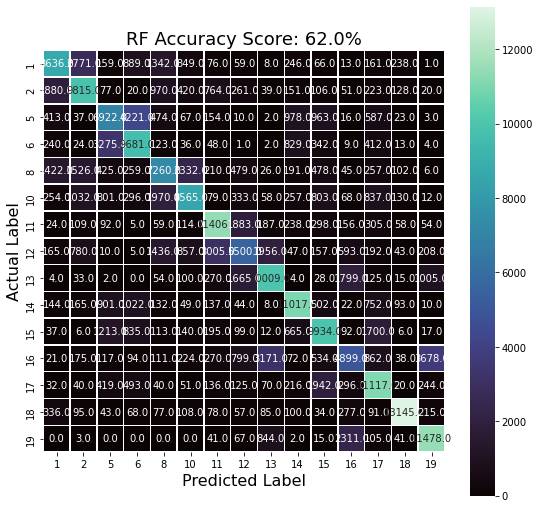

In [37]:
#Print all scores
get_scores(rf2, X_test, y_test)

#Print Confusion Matrix
create_class_matrix(rf2, X_test, y_test)

          importance
B01         0.084926
GARI        0.072100
B12         0.069747
NDVI        0.065816
NDSI        0.065283
GB_NDVI     0.064784
RB_NDVI     0.064073
B11         0.061707
B08         0.060527
B06         0.058550
B09         0.057801
NDWI        0.057329
yellow      0.056528
Moisture    0.056379
B02         0.052810
ARG         0.051642


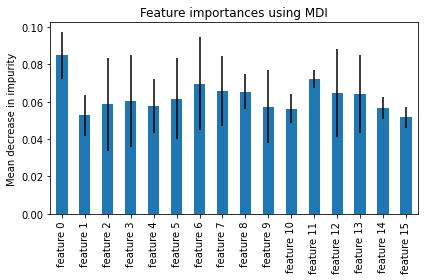

In [38]:
#Print Out Feature Importance Coefficients
print_importance(rf2, X)

#Plot Feature Importance
plot_features(rf2, X)